In [3]:
import os
import numpy as np

from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = 'C:/Users/vinayaka/Downloads/archivee/data'

# List all subdirectories (each representing a class)
classes = os.listdir(dataset_path)
print("Classes found:", classes)

Classes found: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [8]:
# Initialize a counter for the total number of images
total_images = 0

# List all subdirectories (each representing a class)
class_folders = os.listdir(dataset_path)

# Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)
    
    if os.path.isdir(class_path):
        # Count images in the current class folder
        image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        total_images += image_count

print(f'Total number of images in the dataset: {total_images}')

Total number of images in the dataset: 3500


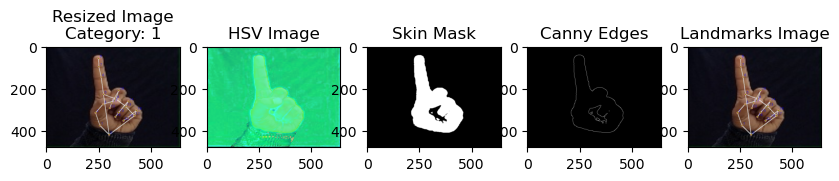

In [10]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths
dataset_path = 'C:/Users/vinayaka/Downloads/archivee/data'  # Adjust this path
output_path1 = 'C:/Users/vinayaka/Downloads/archivee/processed_images1'  # Adjust this path

# Create output directory if it doesn't exist
os.makedirs(output_path1, exist_ok=True)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Set a flag to print only one example
example_printed = False

# Function to extract features (dummy implementation)
def extract_features(hand_landmarks):
    # Implement your feature extraction logic here
    return []

# Iterate through each class folder
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    
    if os.path.isdir(class_path):
        # Iterate through each image in the class folder
        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(class_path, image_name)
                image = cv2.imread(image_path)
                
                # Resize the image
                resized_image = cv2.resize(image, (640, 480))

                # Convert the image to HSV
                hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

                # Create a skin mask (using HSV range for skin color detection)
                lower_skin = np.array([0, 20, 70], dtype=np.uint8)
                upper_skin = np.array([20, 255, 255], dtype=np.uint8)
                skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

                # Apply Canny edge detection
                edges = cv2.Canny(skin_mask, 100, 200)

                # Process the image to find hands
                results = hands.process(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        # Draw hand landmarks
                        mp_drawing.draw_landmarks(resized_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                        # Extract features (if needed)
                        features = extract_features(results.multi_hand_landmarks)
                        
                        # Draw smaller circles for each landmark and label them
                        for i, landmark in enumerate(hand_landmarks.landmark):
                            h, w, _ = resized_image.shape
                            cx, cy = int(landmark.x * w), int(landmark.y * h)
                            cv2.circle(resized_image, (cx, cy), 2, (0, 255, 0), -1)  # Smaller green circles
                            cv2.putText(resized_image, str(i), (cx + 5, cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)  # Label the landmarks

                # Save processed images to output directory
                processed_class_path = os.path.join(output_path1, class_folder)
                os.makedirs(processed_class_path, exist_ok=True)

                cv2.imwrite(os.path.join(processed_class_path, f'{os.path.splitext(image_name)[0]}_resized.jpg'), resized_image)
                cv2.imwrite(os.path.join(processed_class_path, f'{os.path.splitext(image_name)[0]}_hsv.jpg'), hsv_image)
                cv2.imwrite(os.path.join(processed_class_path, f'{os.path.splitext(image_name)[0]}_skin_mask.jpg'), skin_mask)
                cv2.imwrite(os.path.join(processed_class_path, f'{os.path.splitext(image_name)[0]}_edges.jpg'), edges)

                # Save the image with landmarks
                cv2.imwrite(os.path.join(processed_class_path, f'{os.path.splitext(image_name)[0]}_landmarks.jpg'), resized_image)

                # Perform data augmentation and save augmented images
                image_array = np.expand_dims(resized_image, axis=0)
                save_prefix = os.path.join(processed_class_path, os.path.splitext(image_name)[0] + '_aug')

                for i, augmented_image in enumerate(datagen.flow(image_array, batch_size=1, save_to_dir=processed_class_path, save_prefix=save_prefix, save_format='jpg')):
                    if i >= 5:  # Generate 5 augmented images per original image
                        break

                # Print only one example of the processed images with category
                if not example_printed:
                    plt.figure(figsize=(10, 8))
                    plt.subplot(1, 5, 1)
                    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
                    plt.title(f'Resized Image\nCategory: {class_folder}')
                    
                    plt.subplot(1, 5, 2)
                    plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_RGB2HSV))
                    plt.title(f'HSV Image')
                    
                    plt.subplot(1, 5, 3)
                    plt.imshow(skin_mask, cmap='gray')
                    plt.title(f'Skin Mask')
                    
                    plt.subplot(1, 5, 4)
                    plt.imshow(edges, cmap='gray')
                    plt.title(f'Canny Edges')
                    
                    plt.subplot(1, 5, 5)
                    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
                    plt.title(f'Landmarks Image')
                    
                    plt.show()

                    example_printed = True

# Clean up
hands.close()


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
processed_data_path = 'C:/Users/vinayaka/Downloads/archivee/processed_images1'

# Initialize ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    validation_split=0.2          # Use 20% of the data for validation
)

# Load training data
train_generator = datagen.flow_from_directory(
    directory=processed_data_path,
    target_size=(128, 128),       # Resize images to match the input size of your model
    batch_size=32,
    class_mode='categorical',     # For multi-class classification
    subset='training'             # Specify that this generator is for training data
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    directory=processed_data_path,
    target_size=(128, 128),       # Resize images to match the input size of your model
    batch_size=32,
    class_mode='categorical',     # For multi-class classification
    subset='validation'           # Specify that this generator is for validation data
)


Found 30799 images belonging to 35 classes.
Found 7694 images belonging to 35 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)     

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Adjust epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/20


962/962 [==============================] - 335s 346ms/step - loss: 1.1074 - accuracy: 0.6794 - val_loss: 0.1808 - val_accuracy: 0.9605
Epoch 2/20
962/962 [==============================] - 337s 350ms/step - loss: 0.2642 - accuracy: 0.9146 - val_loss: 0.0376 - val_accuracy: 0.9909
Epoch 3/20
962/962 [==============================] - 332s 345ms/step - loss: 0.1595 - accuracy: 0.9495 - val_loss: 0.0298 - val_accuracy: 0.9928
Epoch 4/20
962/962 [==============================] - 331s 344ms/step - loss: 0.1112 - accuracy: 0.9631 - val_loss: 0.0340 - val_accuracy: 0.9911
Epoch 5/20
962/962 [==============================] - 337s 351ms/step - loss: 0.0978 - accuracy: 0.9689 - val_loss: 0.0262 - val_accuracy: 0.9914
Epoch 6/20
962/962 [==============================] - 336s 349ms/step - loss: 0.0667 - accuracy: 0.9776 - val_loss: 0.0163 - val_accuracy: 0.9941
Epoch 7/20
962/962 [==============================] - 318s 330ms/step - loss: 0.0685 - accuracy: 0.9782 - val_loss: 0.0192

In [14]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


240/240 [==============================] - 43s 180ms/step - loss: 0.0050 - accuracy: 0.9982
Validation Loss: 0.0050
Validation Accuracy: 0.9982


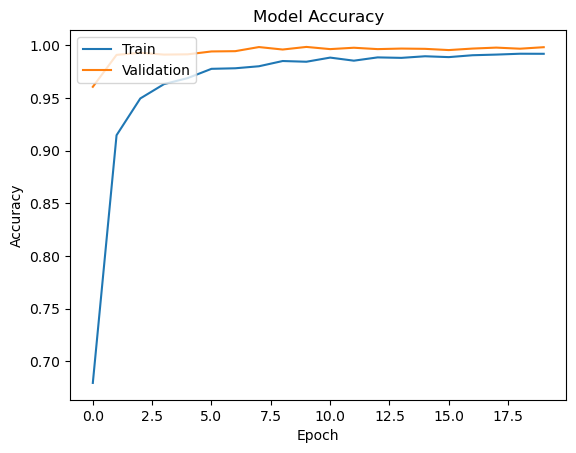

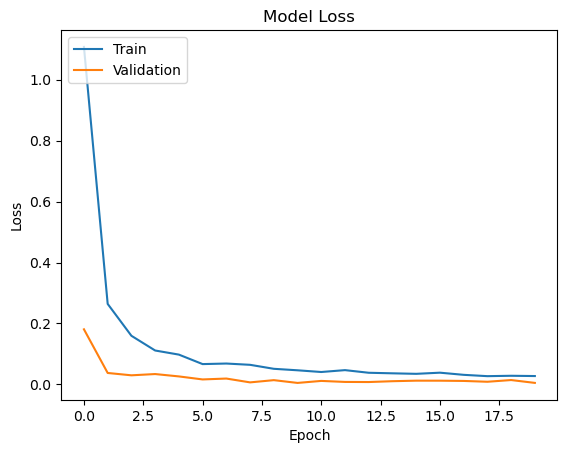

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
model.save('model_sign.keras')


In [1]:
from tensorflow.keras.models import load_model

model = load_model('model_sign.keras')


1/1 [==============================] - 0s 123ms/step
Predicted class: Q


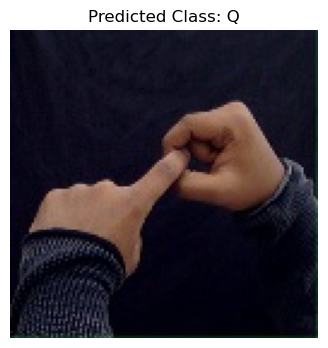

In [8]:

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'C:/Users/vinayaka/Downloads/archive 2/data/Q/599.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = classes[predicted_class[0]]

# Print the predicted class
print(f'Predicted class: {predicted_label}')

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')  # Hide axis
plt.show()


1/1 [==============================] - 1s 742ms/step


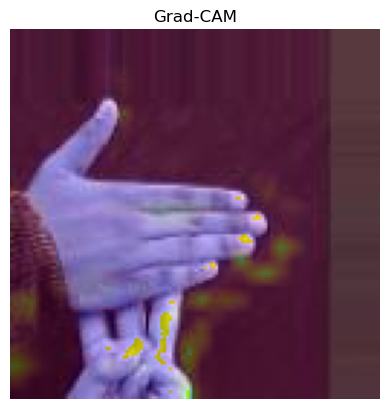

In [11]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, image, class_idx, layer_name):
    # Create a model that returns both the activations and the predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]
    
    # Compute gradients of the loss w.r.t the conv_outputs
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients across the feature map dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Create a heatmap
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads.numpy())
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize
    
    return heatmap

def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to match original image
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
    heatmap = cv2.applyColorMap(heatmap, colormap)  # Apply colormap
    superimposed_img = heatmap * alpha + image  # Overlay heatmap on the image
    return np.uint8(superimposed_img)

# Get a test image from the validation set
test_image, test_label = validation_generator.next()
test_image = test_image[0:1]  # Use a single image

# Predict class
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions[0])

# Get the name of the last convolutional layer
layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

# Compute Grad-CAM
heatmap = grad_cam(model, test_image, predicted_class, layer_name)

# Convert image to uint8 for visualization
test_image_uint8 = (test_image[0] * 255).astype(np.uint8)

# Overlay the heatmap
superimposed_img = overlay_heatmap(heatmap, test_image_uint8)

# Plot the result
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


In [2]:
import os
import numpy as np
# List all subdirectories (each representing a class)
processed_data_path = 'C:/Users/vinayaka/Downloads/archivee/processed_images1'
classes1 = os.listdir(processed_data_path)
print("Classes found:", classes1)

Classes found: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [10]:
pip install gtts

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for gtts from https://files.pythonhosted.org/packages/f5/f9/7f0e837880282ffad7598ae4b80b29c2cdc5f5e75a58602c66518d245afb/gTTS-2.5.3-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [20]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from gtts import gTTS

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Capture video from webcam
cap = cv2.VideoCapture(0)
# Initialize a list to build the sentence
sentence = []

def extract_hand_features(hand_landmarks):
    features = []
    for landmark in hand_landmarks.landmark:
        features.extend([landmark.x, landmark.y])
    return features

def preprocess_features(features):
    # Normalize features
    normalized_features = np.array(features) / 1.0  # Adjust normalization if needed
    return normalized_features

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Process the image to find hands
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Resize the frame for the model
    frame_resized = cv2.resize(frame, (128, 128))
    frame_normalized = frame_resized / 255.0  # Normalize to [0, 1]

    # Predict sign class using the resized frame
    prediction = model.predict(np.expand_dims(frame_normalized, axis=0))
    predicted_class_index = np.argmax(prediction)

    # Get the predicted label from the classes list
    predicted_label = classes1[predicted_class_index]
    
    # Display the predicted sign class
    cv2.putText(frame, f"Predicted Sign: {predicted_label}", 
                (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Add predicted label to the sentence when Enter is pressed
    if cv2.waitKey(1) & 0xFF == 13:  # 13 is the Enter key
        sentence.append(predicted_label)
    # Add space when Space key is pressed
    elif cv2.waitKey(1) & 0xFF == 32:  # 32 is the Space key
        sentence.append(" ")  # Append a space

    # Display the current sentence
    cv2.putText(frame, f"Sentence: {''.join(sentence)}", 
                (10, 70), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    if cv2.waitKey(1) & 0xFF == 27:  # 27 is the Esc key
        if sentence:
            # Convert the sentence to audio
            audio_sentence = ''.join(sentence).strip()  # Create a single string
            tts = gTTS(text=audio_sentence, lang='en')
            tts.save("output.mp3")
            os.system("start output.mp3")  # Use "start" on Windows, "open" on macOS, or "xdg-open" on Linux
        break

    cv2.imshow('Frame', frame)
    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 16ms/step


C:\Users\vinayaka\AppData\Roaming\Python\Python311\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 20ms/step
